Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function

This is done with PCE.

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function
# This is done with PCE.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
np.__version__

'1.20.3'

In [3]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [4]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [5]:
# Define parameter space
def define_params():
    return {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [6]:
# Define parameter space
def define_vary():
    return {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

In [7]:
# Set up and run a campaign
def run_campaign(pce_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_pce."
    my_campaign = uq.Campaign(name='Ishigami_pce.')

    # Create an encoder and decoder for PCE test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=define_params(), actions=actions)

    # Create the sampler
    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.PCESampler(vary=define_vary(), polynomial_order=pce_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute(sequential=True).collate(progress_bar=True)

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, pce_order, my_campaign.get_active_sampler().count

In [8]:
# Calculate the polynomial chaos expansion for a range of orders

R = {}
for pce_order in range(1, 21):
    R[pce_order] = {}
    (R[pce_order]['results_df'], 
     R[pce_order]['results'], 
     R[pce_order]['times'], 
     R[pce_order]['order'], 
     R[pce_order]['number_of_samples']) = run_campaign(pce_order=pce_order, use_files=False)

100%|██████████| 27/27 [00:00<00:00, 5230.77it/s]

Time for phase 1 = 0.024
Number of samples = 8
Time for phase 2 = 0.047
Time for phase 3 = 0.014
Time for phase 4 = 0.005
Time for phase 5 = 0.025
Time for phase 6 = 0.001
Time for phase 1 = 0.009
Number of samples = 27
Time for phase 2 = 0.067
Time for phase 3 = 0.010
Time for phase 4 = 0.003



100%|██████████| 64/64 [00:00<00:00, 5296.67it/s]

Time for phase 5 = 0.096
Time for phase 6 = 0.001
Time for phase 1 = 0.010
Number of samples = 64
Time for phase 2 = 0.110
Time for phase 3 = 0.018
Time for phase 4 = 0.003



  0%|          | 0/125 [00:00<?, ?it/s]

Time for phase 5 = 0.157
Time for phase 6 = 0.001
Time for phase 1 = 0.010
Number of samples = 125
Time for phase 2 = 0.166


100%|██████████| 125/125 [00:00<00:00, 5285.91it/s]


Time for phase 3 = 0.032
Time for phase 4 = 0.004
Time for phase 5 = 0.283
Time for phase 6 = 0.001
Time for phase 1 = 0.010


100%|██████████| 216/216 [00:00<00:00, 5836.12it/s]

Number of samples = 216
Time for phase 2 = 0.211
Time for phase 3 = 0.047
Time for phase 4 = 0.005


Time for phase 5 = 0.471
Time for phase 6 = 0.001
Time for phase 1 = 0.010


100%|██████████| 343/343 [00:00<00:00, 5718.76it/s]

Number of samples = 343
Time for phase 2 = 0.289
Time for phase 3 = 0.074
Time for phase 4 = 0.010


Time for phase 5 = 0.791
Time for phase 6 = 0.001
Time for phase 1 = 0.010


100%|██████████| 512/512 [00:00<00:00, 5851.09it/s]

Number of samples = 512
Time for phase 2 = 0.430
Time for phase 3 = 0.106
Time for phase 4 = 0.008


Time for phase 5 = 1.280
Time for phase 6 = 0.001
Time for phase 1 = 0.010


100%|██████████| 729/729 [00:00<00:00, 4464.29it/s]

Number of samples = 729
Time for phase 2 = 0.519
Time for phase 3 = 0.192


Time for phase 4 = 0.015
Time for phase 5 = 2.201
Time for phase 6 = 0.001
Time for phase 1 = 0.010


100%|██████████| 1000/1000 [00:00<00:00, 5868.68it/s]

Number of samples = 1000
Time for phase 2 = 0.644


Time for phase 3 = 0.203
Time for phase 4 = 0.018
Time for phase 5 = 3.657
Time for phase 6 = 0.001
Time for phase 1 = 0.011


 89%|████████▊ | 1181/1331 [00:00<00:00, 5912.09it/s]

Number of samples = 1331
Time for phase 2 = 0.809


100%|██████████| 1331/1331 [00:00<00:00, 5859.77it/s]


Time for phase 3 = 0.272
Time for phase 4 = 0.023
Time for phase 5 = 6.329
Time for phase 6 = 0.002
Time for phase 1 = 0.011


 68%|██████▊   | 1180/1728 [00:00<00:00, 5902.33it/s]

Number of samples = 1728
Time for phase 2 = 1.090


100%|██████████| 1728/1728 [00:00<00:00, 5902.85it/s]


Time for phase 3 = 0.351
Time for phase 4 = 0.029
Time for phase 5 = 9.810
Time for phase 6 = 0.002
Time for phase 1 = 0.011


 27%|██▋       | 592/2197 [00:00<00:00, 5916.15it/s]

Number of samples = 2197
Time for phase 2 = 1.284


100%|██████████| 2197/2197 [00:00<00:00, 5937.13it/s]


Time for phase 3 = 0.445
Time for phase 4 = 0.033
Time for phase 5 = 15.612
Time for phase 6 = 0.002
Time for phase 1 = 0.010


  0%|          | 0/2744 [00:00<?, ?it/s]

Number of samples = 2744
Time for phase 2 = 1.560


100%|██████████| 2744/2744 [00:00<00:00, 5545.71it/s]


Time for phase 3 = 0.637
Time for phase 4 = 0.041
Time for phase 5 = 23.805
Time for phase 6 = 0.002
Time for phase 1 = 0.011


  0%|          | 0/3375 [00:00<?, ?it/s]

Number of samples = 3375
Time for phase 2 = 1.993


100%|██████████| 3375/3375 [00:00<00:00, 5548.56it/s]


Time for phase 3 = 0.724
Time for phase 4 = 0.048
Time for phase 5 = 37.364
Time for phase 6 = 0.005
Time for phase 1 = 0.013
Number of samples = 4096
Time for phase 2 = 2.655


100%|██████████| 4096/4096 [00:00<00:00, 5256.85it/s]


Time for phase 3 = 0.993
Time for phase 4 = 0.113
Time for phase 5 = 56.946
Time for phase 6 = 0.005
Time for phase 1 = 0.012
Number of samples = 4913
Time for phase 2 = 3.106


100%|██████████| 4913/4913 [00:00<00:00, 5553.91it/s]


Time for phase 3 = 1.113
Time for phase 4 = 0.069
Time for phase 5 = 82.249
Time for phase 6 = 0.008
Time for phase 1 = 0.013
Number of samples = 5832
Time for phase 2 = 3.835


100%|██████████| 5832/5832 [00:01<00:00, 4902.66it/s]


Time for phase 3 = 1.395
Time for phase 4 = 0.140
Time for phase 5 = 110.955
Time for phase 6 = 0.004
Time for phase 1 = 0.014
Number of samples = 6859
Time for phase 2 = 4.523


100%|██████████| 6859/6859 [00:01<00:00, 5997.21it/s]


Time for phase 3 = 1.416
Time for phase 4 = 0.138
Time for phase 5 = 157.775
Time for phase 6 = 0.009
Time for phase 1 = 0.013
Number of samples = 8000
Time for phase 2 = 5.506


100%|██████████| 8000/8000 [00:01<00:00, 5908.61it/s]


Time for phase 3 = 1.674
Time for phase 4 = 0.106
Time for phase 5 = 223.365
Time for phase 6 = 0.010
Time for phase 1 = 0.017
Number of samples = 9261
Time for phase 2 = 6.638


100%|██████████| 9261/9261 [00:01<00:00, 5866.64it/s]


Time for phase 3 = 2.014
Time for phase 4 = 0.175
Time for phase 5 = 305.590
Time for phase 6 = 0.012


In [9]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [10]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.116890,0.023561,0.047494,0.014364,0.004727,0.025145,0.001371
2,0.185215,0.008758,0.066634,0.010111,0.003107,0.095731,0.000704
3,0.299404,0.009978,0.110162,0.018265,0.003309,0.156721,0.000741
4,0.495586,0.010213,0.165519,0.031726,0.003938,0.283012,0.000999
5,0.744587,0.009684,0.211016,0.047231,0.004952,0.470695,0.000839
6,1.173968,0.009920,0.288732,0.073867,0.009684,0.790635,0.000920
7,1.835404,0.010054,0.429832,0.105503,0.008388,1.280335,0.001104
8,2.938434,0.009634,0.519347,0.192273,0.014560,2.201186,0.001187
9,4.534584,0.010474,0.644228,0.203496,0.017964,3.656723,0.001494
10,7.445591,0.010810,0.808591,0.271519,0.023036,6.329216,0.002161


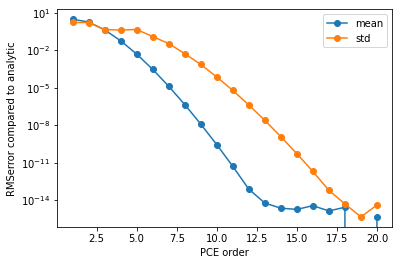

In [11]:
# plot the convergence of the mean and standard deviation to that of the highest order

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('PCE order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

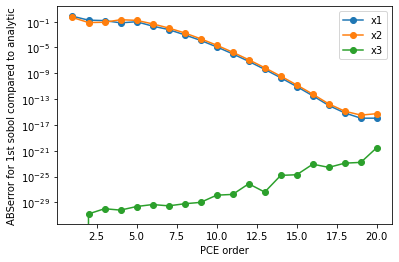

In [12]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('PCE order')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

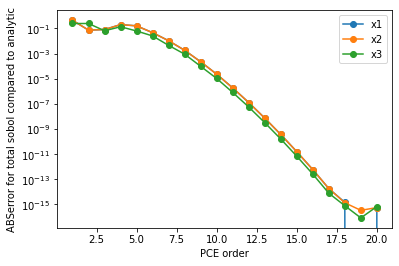

In [13]:
# plot the convergence of the total sobol to that of the highest order

sobol_total_exact = {'x1': exact['ST1'], 'x2': exact['ST2'], 'x3': exact['ST3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_total('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_total('Ishigami')[v] - sobol_total_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('PCE order')
plt.ylabel('ABSerror for total sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_total.png')
plt.savefig('Convergence_sobol_total.pdf')

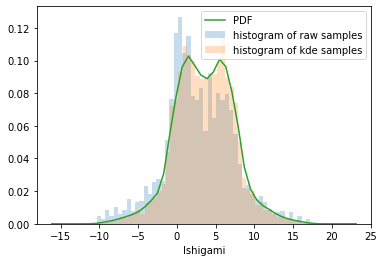

In [14]:
# Plot the distribution function

results_df = R[O[-1]]['results_df']
results = R[O[-1]]['results']
Ishigami_dist = results.raw_data['output_distributions']['Ishigami']

plt.figure()
plt.hist(results_df.Ishigami[0], density=True, bins=50, label='histogram of raw samples', alpha=0.25)
if hasattr(Ishigami_dist, 'samples'):
    plt.hist(Ishigami_dist.samples[0], density=True, bins=50, label='histogram of kde samples', alpha=0.25)
t1 = Ishigami_dist[0]
plt.plot(np.linspace(t1.lower, t1.upper), t1.pdf(np.linspace(t1.lower,t1.upper)), label='PDF')
plt.legend(loc=0)
plt.xlabel('Ishigami')
plt.savefig('Ishigami_distribution_function.png')

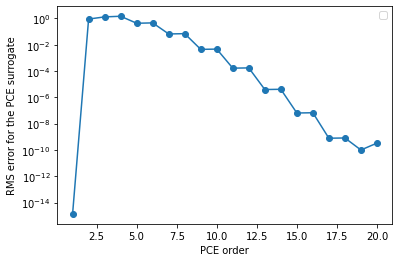

In [15]:
# plot the RMS surrogate error at the PCE vary points
_o = []
_RMS = []
for r in R.values():
    results_df = r['results_df']
    results = r['results']
    Ishigami_surrogate = np.squeeze(np.array(results.surrogate()(results_df[results.inputs])['Ishigami']))
    Ishigami_samples = np.squeeze(np.array(results_df['Ishigami']))
    _RMS.append((np.sqrt((((Ishigami_surrogate - Ishigami_samples))**2).mean())))
    _o.append(r['order'])

plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
plt.savefig('Convergence_surrogate.png')
plt.savefig('Convergence_surrogate.pdf')

In [16]:
# prepare the test data
test_campaign = uq.Campaign(name='Ishigami.')        
test_campaign.add_app(name="Ishigami", params=define_params(), 
                      actions=uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model)))
test_campaign.set_sampler(uq.sampling.quasirandom.LHCSampler(vary=define_vary(), count=100))
test_campaign.execute(nsamples=1000, sequential=True).collate(progress_bar=True)
test_df = test_campaign.get_collation_result()

100%|██████████| 1000/1000 [00:00<00:00, 5818.48it/s]


In [17]:
# calculate the PCE surrogates
test_points = test_df[test_campaign.get_active_sampler().vary.get_keys()]
test_results = np.squeeze(test_df['Ishigami'].values)
test_predictions = {}
for i in list(R.keys()):
    test_predictions[i] = np.squeeze(np.array(R[i]['results'].surrogate()(test_points)['Ishigami']))

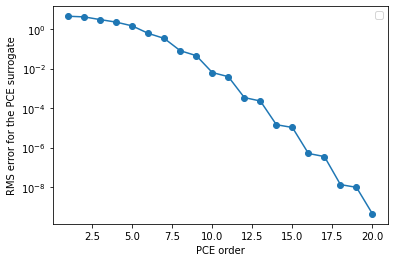

In [18]:
# plot the convergence of the surrogate
_o = []
_RMS = []
for r in R.values():
    _RMS.append((np.sqrt((((test_predictions[r['order']] - test_results))**2).mean())))
    _o.append(r['order'])

plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
plt.savefig('Convergence_PCE_surrogate.png')
plt.savefig('Convergence_PCE_surrogate.pdf')